# Expanding network connectivity modeling to recover simulated task activity using connectivity matrix


Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/zenkavi/.pyenv/versions/3.8.0/envs/workbase/lib/python3.8/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Import custom modules

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../utils/')

# Helper functions for eGLM 
from eGLM_helpers import phi, run_ucr_glm, run_ext_glm, make_stimtimes, sim_network_task_glm, get_res_ts, get_res_taskreg, get_true_baseline, plot_sim_network_glm

Importing eGLM helpers...
All eGLM helpers imported!



## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf) and [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

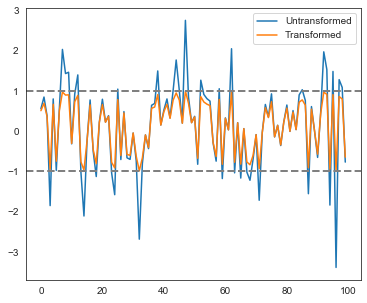

In [3]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

In Ito et al. (2017) $\tau_i$, $s$, $g$ and $dt$ are set to 1. This simplifies the equation to:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

Note in the synaptic connectivity weight matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

`taskdata` is an $n$ by $t$ matrix containing the timeseries for each node where $n$-rows are for nodes and $t$ columns are for the time points.

It is generated by updating each column (each time point) for **all nodes**  

At each time point the differential equation describing the change in activity is solved using the [Runge-Kutta second order method](https://lpsa.swarthmore.edu/NumInt/NumIntSecond.html). Runge-Kutta methods are used to discretize the problem of updating values for continuous time when solving differential equations. Ito et al. hypothesize the differential equation determining the amount of change in each timestep as:

\begin{equation*}
\frac{dx_i}{dt} = \frac{-x_i(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + s\phi\big(x_i(t)\big) + I_i(t)}{\tau_i}
\end{equation*}

Thus `taskdata` for all nodes $x_i$ consists of the current activity plus a weighted sum of approximate changes in activity calculated using the differential equation.

\begin{equation*}
x_{i}(t+dt) = x_{i}(t) + \frac{k1_{i}+k2_{i}}{2}
\end{equation*}

The first derivative based on $t(0)$ that is used for the approximation is

\begin{equation*}
k1_{i} = \frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

$\hat{I}_{i}(t)$ is the spontaneous activity that is the sum of randomly generated noise and task-related stimulation ($\hat{I}_{i}(t) = {I}_{i}(t)+\epsilon(t)$). Since the column-vector of task-related stimulation activity is very sparse ($|I_{i}(t)| \neq 0$ only for $i$ that is the third of the hub nodes and only for a short window of timepoints $t$) **most of the activity feeds into updating the activity of a node is noise (which in this framework is the equivalent of rest activity)**.

Using this slope the first intermediate approximation at the endpoint is

\begin{equation*}
x_{i}^*(t+dt) = x_{i}(t) + k1_{i} dt
\end{equation*}

and the second order approximation for the change in activity is

\begin{equation*}
k2_{i} = \frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}
\end{equation*}

If we discretize and work through the algebra the row-wise (node-centric) 'expanded' GLM for the column-wise (timepoint-centric) generated data using the Runge-Kutte method would be:

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{k1_{i}+k2_{i}}{2}
\end{equation*}

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

Replacing $x_{i}^*(t+dt)$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}(t) - k1_{i} dt + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

To write out a general equation for $x_i(t+1)$ first we replace the $k1_i$ in the equation. Since $k1_i$ appears always in the context of $x_i(t)+k1_idt$ we plug in the formula for $k1_i$ into this expression and simplify

\begin{equation*}
x_{i}(t) + k1_{i}dt = x_{i}(t)+dt\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

\begin{equation*}
x_{i}(t) + k1_{i}dt = \frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]
\end{equation*}


Then we use this expression in the formula of $x_{i}(t+1)$ 

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \big(x_{i}(t) + k1_{i} dt\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Plugging in $x_{i}(t) + k1_{i}dt$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Simplifying common terms

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[\frac{dt-2\tau}{\tau}x_{i}(t) + \frac{\tau-dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg] + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Extracting $x_{i}(t)$ outside the rest of the expression

\begin{equation*}
x_{i}(t+1) = \frac{2\tau^2+dt(dt-2\tau)}{2\tau^2}x_{i}(t) + \frac{dt}{2\tau}\Bigg[\frac{\tau-dt}{\tau}\Bigg(g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg(g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg)\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

This is a pretty messy expression. In words it describes the activity in the next time point for a node as a function of:
- current node activity 
- current activity depending on connectivity with other nodes, local connectivity and task stimulation 
- activity in the next time step depending on connectivity with other nodes, first order approximation in the current node and task stimulation  
all of which are weigted by different constants that depends on the time steps

Note that when $dt = \tau$ some regressors will be columns of 0's so their parameter estimates will be meaningless.

We can use this equation to expand the traditinal GLM. A traditional GLM would have modeled

\begin{equation*}
x_{i}(t) \sim I(t)
\end{equation*}

that is the activity of a voxel at a given time point would have been a function of the convolved task activity for that node at that time point plus some noise (For these simulations we ignore other movement confounds etc. included in level 1 models in real data).  

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. Is the same thing as 'subtracting out' resting state to look at the remaining task activity?


## Baseline simulation

First we simulate a topdown task that stimulates nodes only in the hub network. No noise is added to this simulation. It is intended to serve as a baseline to compare the changes for all the tests below. 

The plot below will serve as a template for several tests later in this notebook.
The x-axis denotes each node and the y-axis the regression coefficient between the task activity and each nodes' time series. The blue line shows the parameters using the classic GLM framework (cGLM) and the yellow line are the parameter estimates when the time series is corrected for its connectivity with the rest of the network using the extended GLM equation above (eGLM). The vertical lines denote community boundaries. In the baseline simulation there is one hub network and two local networks. The horizontal line depicts the expected magnitude of the task parameter accounting for that nodes connectivity and stimulation status (detailed below).

In [4]:
base_sim = sim_network_task_glm(noise=None)

Text(85, 3.5, 'Local 2')

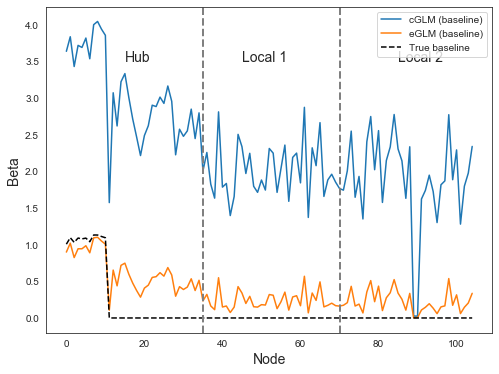

In [5]:
plot_sim_network_glm(data = base_sim, base_label = "True baseline")
plt.text(x = 15, y = 3.5, s = "Hub", fontsize = 14)
plt.text(x = 45, y = 3.5, s = "Local 1", fontsize = 14)
plt.text(x = 85, y = 3.5, s = "Local 2", fontsize = 14)

With the change in the GLM equation the task parameter estimates can get change in two ways:

- bias [change in mean]: the relationship between the timeseries and task regressor becomes stronger or weaker on average
- variance [more variable estimates]: the relationship between the timeseries and the task regressor varies more across nodes. Since the task regressor is the same for all nodes (we wouldn't empirically know which nodes are stimulated by it) this increased variability would have to be due to increased variability in the timeseries across nodes. 

## Different noise levels

In [6]:
td_stimtimes_0_5 = make_stimtimes(Tmax=10000, dt=1, stim_nodes=base_sim['stim_nodes'], stim_mag=0.5)

In [7]:
noise_ts = {}

noise_sds = [0, .5, 1, 2, 5]

In [8]:
for noise_sd in noise_sds:
    var_name = "noise_"+str(noise_sd)
    noise_ts[var_name] = sim_network_task_glm(W = base_sim['W'],Tmax=10000,dt=1,g=1,s=1,tau=1, noise=1, noise_scale = noise_sd)
    

First we examine the effect of different amounts of noise. When the noise parameter is turned on a random number from a normal distribution with a mean of 0 and specified standard deviation is added to the activity level at each time point. The amount of noise is changed by modifying the variance of this distribution and leaving the mean at 0. 

Below we plot time series for a stimulated and non-stimulated node for varying levels of noise. The time series without noise points out the amplification of the task signal through connections to the rest of the network. This is why the activity for a non-stimulated node (right plot) is not at 0 for the whole task either. Importantly, this suggests that the "correct" baseline that the task activity parameter estimates should be compared to is not the stimulus timing for each node but the remaining relationship between the time series and task timing once the amplification through the rest of the network is accounted for.

Text(0.5, 1.0, 'Non-stimulated node')

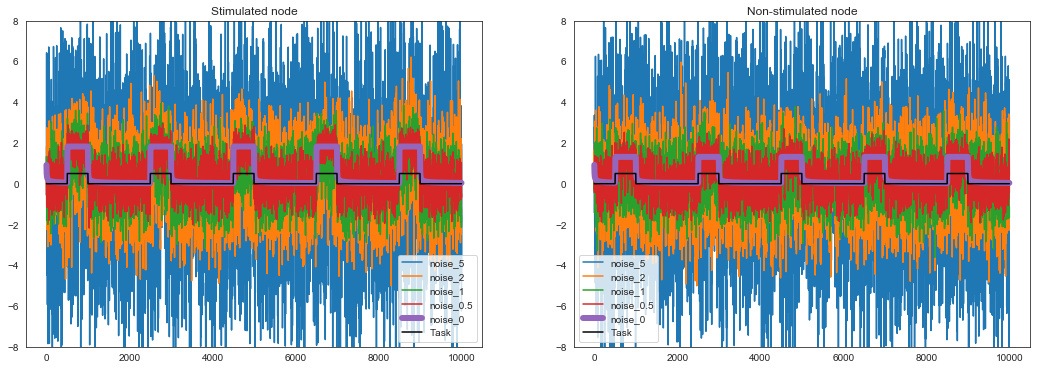

In [9]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6

#Plot same stimulated node's timeseries with and without noise
fig,a =  plt.subplots(1,2)
curns = [0, 21]
rkeys = list(noise_ts.keys())
rkeys.reverse()
for i in range(2):
    curn = curns[i]
    for j in rkeys:
        if j == 'noise_0':
            a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), noise_ts[j]['taskdata'][curn,:], linewidth = 6,label=j)
        else:
            a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), noise_ts[j]['taskdata'][curn,:],label=j)
    a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), td_stimtimes_0_5[0], label="Task", color="black")
    a[i].legend(loc="best")
    a[i].set_ylim([-8,8])
    
a[0].set_title("Stimulated node")
a[1].set_title("Non-stimulated node")

The effect of adding noise to the timeseries has different effects on the task parameter estimates using the two approaches.  

For the classic GLM:
- without noise the overestimation for all nodes is the worst
- with noise the correct baselines initially decrease dramatically and then approach the baseline of no noise.
- with more noise the estimates get closer to their lower true baselines as well, though the overestimation remains a problem throughout.

For the extended GLM
- without noise the parameter estimates improve drastically (as shown above) but there is still some overestimation of stimulated nodes' parameters.
- with the addition of noise all parameter estimates descrease even further initially but approach the no noise estimates as noise increases.

In [10]:
values = ["C"+str(x) for x in range(len(noise_ts.keys()))]
col_lookup = dict(zip(rkeys, values))

Text(0.5, 1.0, 'Extended GLM')

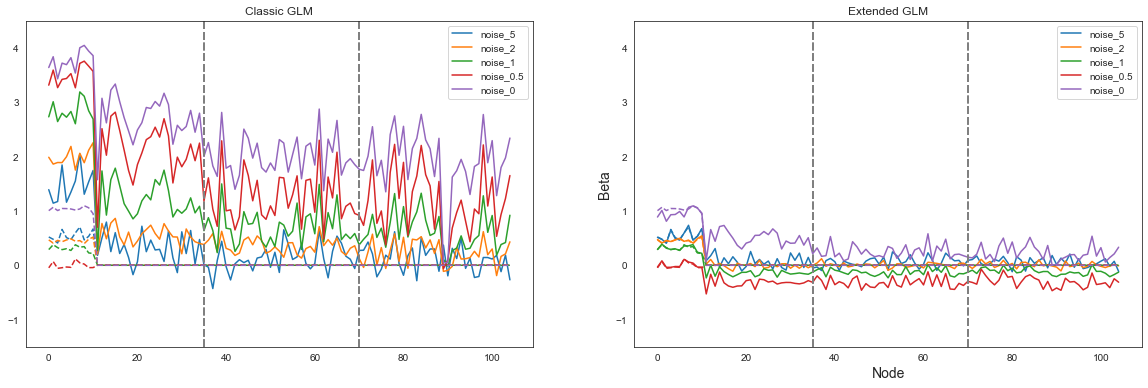

In [12]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a =  plt.subplots(1,2)

#task_betas = [{k:v['ucr_task_betas'] for k,v in ucr_glms.items()}, {k:v['ext_task_betas'] for k,v in ext_glms.items()}]
beta_keys = ['ucr_betas', 'ext_betas']
for i, bk in enumerate(beta_keys):
    for j in rkeys:
        a[i].plot(noise_ts[j][bk], label = j, color = col_lookup[j])
        
        #if j == "noise_0":
        #    stim_baseline, nonstim_baseline = get_true_baseline(noise_ts[j])
        #else:
        #    stim_baseline, nonstim_baseline = get_true_baseline(noise_ts[j], noise=True)
        
        baseline_vec = get_true_baseline(noise_ts[j])
        
        #a[i].plot(np.concatenate((np.repeat(stim_baseline, 11), np.repeat(nonstim_baseline,94))), 
        #         color = col_lookup[j], linestyle = '--')
        a[i].plot(baseline_vec, 
                  color = col_lookup[j], linestyle = '--')
    
        for n in range(1,3):
            a[i].axvline(x=35*n,linewidth=2, color='gray', ls = "--")
        a[i].legend(loc="best")
        a[i].set_ylim([-1.5,4.5])
        
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
a[0].set_title("Classic GLM")
a[1].set_title("Extended GLM")

The reason for the overcorrection of non-stimulated nodes in eGLM with the smallest amount of noise is not immediately apparent. We can understand it better by breaking it down.

How is the corrected time series with a little noise different from the corrected timeseries without noise in how it relates to the task regressor? (see below)
- Without noise the corrected time series of a non-stimulated node goes down to the same constant (0) level whenever the task is on. So the relationship between the task regressor and the timeseries is completely removed.
- With a little bit of noise added to each time point, however, the corrected timeseries of a nonstimulated node hovers around the 0-level, always below the task regressor. Thus, the relationship is not completely removed but systematically but instead becomes negative.
- When noise is increase the magnitude of this hovering at each time point is larger, more frequently going above the task regressor. The relationship between the task regressor and the more nosier corrected time series thus returns to 0 on average.


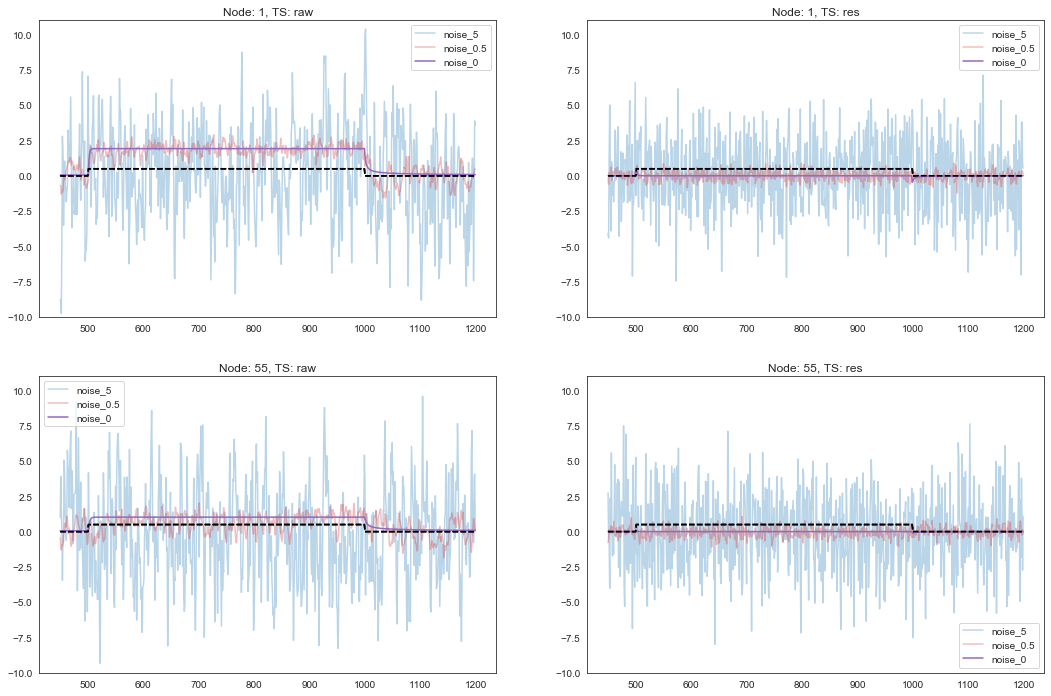

In [13]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 12

#Plot same stimulated node's timeseries with and without noise
fig,a =  plt.subplots(2,2)
curns = [1, 55]
ts_type = ["raw", "res"]
noise_levels = ['noise_5', 'noise_0.5', 'noise_0']

xvals = range(450,1200)

for i, curn in enumerate(curns):
    for j, cur_ts_type in enumerate(ts_type):
        for k, cur_noise in enumerate(noise_levels): 
            if cur_noise != "noise_0":
                alp = 0.3
            else:
                alp = 1
            
            if cur_ts_type == "raw":
                a[i, j].plot(xvals, noise_ts[cur_noise]['taskdata'][curn, xvals],label=cur_noise, color = col_lookup[cur_noise], alpha=alp)
            elif cur_ts_type == "res":
                cur_res_ts = get_res_ts(noise_ts[cur_noise])
                a[i, j].plot(xvals, cur_res_ts[curn, xvals],label=cur_noise, color = col_lookup[cur_noise], alpha=alp)
            a[i, j].plot(xvals, td_stimtimes_0_5[0][xvals], "--", color="black")
            a[i, j].legend(loc="best")
            a[i, j].set_title("Node: " + str(curn) + ", TS: "+ cur_ts_type)
            a[i, j].set_ylim([-10,11])
    


cGLM of residualized TS on original task regressor would not give the same parameter estimates as the eGLM regressing the original TS on the task regressor.

The reason is explained in [this question](https://stats.stackexchange.com/questions/358732/residualizing-dependent-variable-and-two-step-linear-regression) and the [FWL Theorem](https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem).

Accordingly the residualizing projection matrix must be applied to the task regressor when running the model with the residualized TS as the DV.

The projection matrix would be: 

```P = np.dot(np.dot(X, np.linalg.inv(np.dot(X.T, X))), X.T)```

where X is the design matrix without the task regressor

and the residualizing matrix is then:

```M = np.identity(P.shape[0]) - P```

In [29]:
cur_sim = noise_ts['noise_0']
cur_node = 10
plt.rcParams["figure.figsize"][0] = 9
plt.rcParams["figure.figsize"][1] = 6

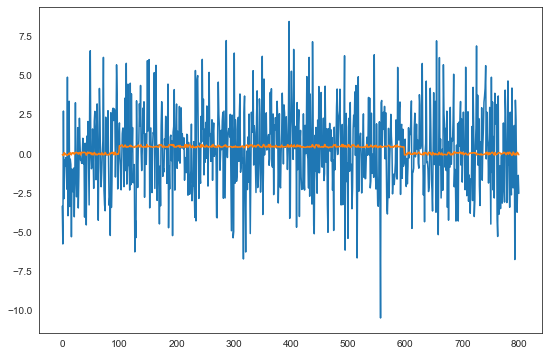

In [31]:
res_y, m_task_reg = get_res_taskreg(noise_ts['noise_5'], 2)
plt.plot(res_y[400:1200])
plt.plot(m_task_reg[400:1200])


(-10, 7.5)

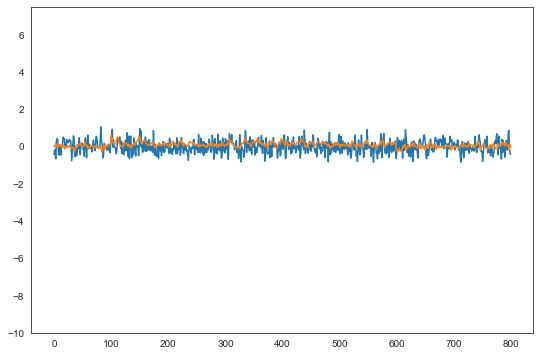

In [32]:
res_y2, m_task_reg2 = get_res_taskreg(noise_ts['noise_0.5'], 2)
plt.plot(res_y2[400:1200])
plt.plot(m_task_reg2[400:1200])
plt.ylim([-10,7.5])

(-10, 7.5)

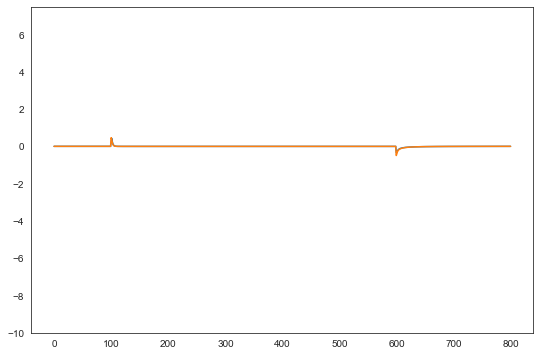

In [34]:
res_y3, m_task_reg3 = get_res_taskreg(noise_ts['noise_0'], 2)
plt.plot(res_y3[400:1200])
plt.plot(m_task_reg3[400:1200])
plt.ylim([-10,7.5])

In [ ]:
x1 = np.random.normal(loc=2, scale = 1, size=1000)
x2 = 1+x1*0.3+np.random.normal(loc=0, scale = 2, size=1000)
x3 = 0.5*x1+0.5*x2+np.random.normal(loc = 1.5, scale = 2, size=1000)

y = x1+2*x2+x3+np.random.normal(loc=0, scale=1, size=1000)

df = pd.DataFrame(data = {"y":y, "x1": x1, "x2": x2/2, "x3":x3})

m1 = smf.ols(formula = "y~x1+x2+x3", data=df)
m2 = smf.ols(formula = "y~x1+x2", data=df)
df['res_y'] = m2.fit().resid
m3 = smf.ols(formula = "res_y~x3", data=df)

In [ ]:
m1.fit().summary()

In [ ]:
X = m2.exog
p = np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T)
m = np.identity(p.shape[0])-p

In [ ]:
df['m_x3'] = np.dot(m, df['x3'])
m4 = smf.ols(formula = "res_y~m_x3", data=df)

In [ ]:
m4.fit().summary()

## Different network structures

A summary of all changing parameters and their effect on task parameters estimated by both methods can be found in the [Summary](#summary) section.

### Changing network density

#### Innetwork density

The innetwork density controls the probability of a given node to be connected to another node within the same community. In a topdown task (where only the hub network is stimulated) increasing the innetwork density exacerbates the bleeding of true activity from the stimulated nodes onto non-stimulated nodes in the same network.

In [ ]:
new_sim = sim_network_task_glm(innetwork_dsity = .85)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (IND = 0.60)", ext_label="eGLM (IND = 0.60)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (IND = 0.85)", ext_label="eGLM (IND = 0.85)")

#### Outnetwork density

The outnetwork density controls the probability of local networks having outside connections with other local communities. Since this is a topdown task increasing the outnetwork density doesn't have an effect on neither the classic nor eGLM estimates.

In [ ]:
new_sim = sim_network_task_glm(outnetwork_dsity = .25)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (OND = 0.08)", ext_label="eGLM (OND = 0.08)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (OND = 0.25)", ext_label="eGLM (OND = 0.25)")

#### Hub network density

The hub network density controls the probability of a hub node to be connected to other local networks. Increasing it impacts the classic GLM estimates in the local networks by increasing the leakage from the hub network.

In [ ]:
new_sim = sim_network_task_glm(hubnetwork_dsity = .5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (HND = 0.25)", ext_label="eGLM (HND = 0.25)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (HND = 0.50)", ext_label="eGLM (HND = 0.50)")

### Changing number of local communities

Does not lead to any difference for either method.

In [ ]:
new_sim = sim_network_task_glm(ncommunities=4)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label=r"cGLM (ncoms = 3)", ext_label="eGLM (ncoms = 3)", ncoms = 4, width = 10)
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (ncoms = 4)", ext_label="eGLM (ncoms = 4)", ncoms = 4, width = 10)

### Changing information transfer strength (ITS)

The information transfer strength control the degree to which activity incoming from a connected node affects the change in the activity of a given node. One parameter ($g$) controls the degree of change for activity coming from the rest of the network to the node while another ($s$) control the weight of current node's activity for the next time step.

#### Change in time series

Looking at one block of task-on

In [ ]:
#new_sim_g1_s1 = base_sim
new_sim_g0_s0 = sim_network_task_glm(s = 0, g = 0)
new_sim_g0_s1 = sim_network_task_glm(g = 0, s = 1)
new_sim_g1_s0 = sim_network_task_glm(g = 1, s = 0)
new_sim_g5_s1 = sim_network_task_glm(g = 5, s = 1)
new_sim_g5_s0 = sim_network_task_glm(g = 5, s = 0)
new_sim_g1_s5 = sim_network_task_glm(g = 1, s = 5)
new_sim_g0_s5 = sim_network_task_glm(g = 0, s = 5)
new_sim_g5_s5 = sim_network_task_glm(g = 5, s = 5)

gs = [0, 1, 5]
ss = [0, 1, 5]
its_ts = {}

for cur_g in gs:
    for cur_s in ss:
        var_name = "new_sim_g_"+str(g)+'_s_'+str(s)
        its_ts[var_name] = sim_network_task_glm(W = base_sim['W'],Tmax=10000,dt=1,g=1,s=1,tau=1, noise=1, noise_scale = noise_sd)

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

#stim node, non-stim hub node, non-stim local node
plot_nodes = [1, 21, 51]
x_len = td_stimtimes_0_5.shape[1]
x_len = 1200

values = ["C"+str(x) for x in range(len(its_ts.keys()))]
col_lookup = dict(zip(its_ts.keys(), values))

sims = [new_sim_g0_s0, base_sim, new_sim_g5_s5, new_sim_g1_s0, new_sim_g5_s0, new_sim_g0_s1, new_sim_g0_s5, new_sim_g5_s1, new_sim_g1_s5]

titles = ['g, s = 0','g, s = 1', 'g, s = 5', 'g = 1, s = 0', 'g = 5, s = 0', 'g = 0, s = 1', 'g = 0, s = 5', 'g = 5, s = 1', 'g = 1, s = 5']
fig, a = plt.subplots(1,3)

for i,cur_sim in enumerate(sims):    
    for j,cur_node in enumerate(plot_nodes):
        a[j].plot(range(x_len), cur_sim['taskdata'][cur_node][:x_len], label = str(titles[i]))
        #a[j].plot(range(x_len), td_stimtimes_0_5[0], '--', color = "black")
        a[j].legend(loc = "upper left")
        a[j].set_title("Node: " +str(cur_node))
        a[j].set_ylim([0, 9])

When both $s$ and $g$ are 0 the time series are identical to (true) task timing for that node.

When $s$ is kept constant and $g$ is increased activity is compounded in all nodes ONLY when task is ON. When the global ITS is increased the leakage from stimulated nodes increases. This increases the similarity in the time series of nodes.

When $g$ is kept constant and $s$ is increased a qualitative shift happens when $s>1$. When $s\leq1$ the random activity at the start of the time series diminishes with time. For a stimulated node the activity resulting from stimulation is compounded (to a larger degree than with an increase in $g$ alone) but lack of activity remains the case for nonstimulated nodes (i.e. no leakage since $s$ only affects current node's activity). When $s>1$, however, the random activity in the beginning of the time series is compounded to such a large extent for all nodes that it creates high and spurious (or at least task-unrelated) activity that is also increasingly similar across all nodes.

In [ ]:
sims_res = [get_res_ts(x) for x in sims]

In [ ]:
x_len = range(480,520)

fig, a = plt.subplots(1,3)

for i,cur_sim in enumerate(sims_res):    
    for j,cur_node in enumerate(plot_nodes):
        a[j].plot(x_len, cur_sim[cur_node][x_len], label = str(titles[i]))
        a[j].legend(loc = "upper right")
        a[j].set_title("Node: " +str(cur_node))

#### Change in parameter estimates

Classic glm on left and extended on right

In [ ]:
sims = {"new_sim_g0_s0": new_sim_g0_s0, "base_sim_g1_s1": base_sim, 
        "new_sim_g1_s0": new_sim_g1_s0, "new_sim_g5_s0": new_sim_g5_s0, "new_sim_g0_s1": new_sim_g0_s1, 
        "new_sim_g5_s1": new_sim_g5_s1}

task_betas = [{k:v['ucr_betas'] for k,v in sims.items()}, {k:v['ext_betas'] for k,v in sims.items()}]

stim_baselines=[]
nonstim_baselines=[]

for i in sims.keys():
    stim_baseline, nonstim_baseline = get_true_baseline(sims[i])
    stim_baselines.append(stim_baseline)
    nonstim_baselines.append(nonstim_baseline)



When $g=5$ multicollinearity (similarity of each nodes' timeseries to each other) is so bad that the paramater estimates are very variable for both methods.

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a =  plt.subplots(1,2)

for i in range(len(task_betas)):
    for j, k in enumerate(sims.keys()):
        a[i].plot(task_betas[i][k], label = k, color = col_lookup[k])
        
        a[i].plot(np.concatenate((np.repeat(stim_baselines[j], 11), np.repeat(nonstim_baselines[j],94))), 
                  color = col_lookup[k], linestyle = '--', alpha=.5)
    
        for n in range(1,3):
            a[i].axvline(x=35*n,linewidth=2, color='gray', ls = "--")
        a[i].legend(loc="best")
        a[i].set_ylim([-1,8.5])
        
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
a[0].set_title("Classic GLM")
a[1].set_title("Extended GLM")

Why are the estimates identical for both methods when $s=0$?

In [ ]:
plot_sim_network_glm(data = new_sim_g5_s0, alp=.5, ucr_label="cGLM (g=5, s=0)", ext_label="eGLM (g=5, s=0)")
plot_sim_network_glm(data = new_sim_g1_s0, ucr_label="cGLM (g=1, s=0)", ext_label="eGLM (g=1, s=0)")

In [ ]:
new_sim_g5_s0_n01 = sim_network_task_glm(g = 5, s = 0, noise_scale=.1)

In [ ]:
plot_sim_network_glm(data = new_sim_g5_s0, alp=.5, ucr_label="cGLM (g=5, s=0)", ext_label="eGLM (g=5, s=0)")
plot_sim_network_glm(data = new_sim_g5_s0_n01, ucr_label="cGLM (g=5, s=0)", ext_label="eGLM (g=5, s=0)")

### Changing temporal resolution

Decrease in $dt$ leads to some improvement of classical GLM estimates of stimulated nodes, while increasing it results in noisier estimates for all nodes.

Change in either direction leads to noisier eGLM estimates.


#### Increasing $dt$

In [ ]:
new_sim = sim_network_task_glm(dt=2)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (dt = 1)", ext_label="eGLM (dt = 1)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (dt = 2)", ext_label="eGLM (dt = 2)")

#### Decreasing $dt$

In [ ]:
new_sim = sim_network_task_glm(dt = .5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (dt = 1)", ext_label="eGLM (dt = 1)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (dt = .5)", ext_label="eGLM (dt = .5)")

## Different task structures

The initial task was a top down task that stimulated nodes only in the hub network and trickled activity down to the other nodes.

Other task activations are possible.

Things to modulate:  
- Number of nodes stimulated
- Stimulating only local community
- Stimulating both hub and local community
- Magnitude of stimulation (different from 0.5)

### Changing number of stimulated nodes

Makes the overestimation of non-stimulated node estimates in cGLM and their underestimation in the eGLM slightly worse.

In [ ]:
new_sim = sim_network_task_glm(stimsize = np.floor(35/2))

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (stim_size=11)", ext_label="eGLM (stim_size=11)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (stim_size=17)", ext_label="eGLM (stim_size=17)")

### Stimulating only local community

The new method seems to work expectedly with a bottom-up task that only stimulates a local community. The overestimated task parameters in the stimulated community are greatly improvement by the eGLM though non-stimulated nodes in the same community are again underestimated. 

**DOUBLE CHECK LOCAL NODES WITH CONNECTIONS ARE EXTRACTED CORRECTLY**

Due to its connections to the stimulated local community there is some leakage to the hub community in the cGLM estimates but again is corrected by eGLM.

The second local community's activity is only minimally impacted by the stimulated local community (since any trickling down would come from the hub network). Expectedly both methods do a reasonable job in estimating this lack of stimulation.

In [ ]:
new_sim = sim_network_task_glm(topdown = False, bottomup=True)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (TD)", ext_label="eGLM (TD)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (BU)", ext_label="eGLM (BU)")

### Stimulating both hub and local community



In [ ]:
new_sim = sim_network_task_glm(topdown = True, bottomup=True)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (TD)", ext_label="eGLM (TD)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (TD+BU)", ext_label="eGLM (TD+BU)")

### Changing magnitude of stimulation

In [ ]:
new_sim = sim_network_task_glm(stim_mag = .1)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (stim_mag=0.5)", ext_label="eGLM (stim_mag=0.5)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (stim_mag=0.1)", ext_label="eGLM (stim_mag=0.1)")

<a id='summary'></a>
## Summary